# GD04:Seq2Seq_Translator


8-7. 프로젝트: 한영 번역기 만들기
Step 1. 데이터 다운로드

아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보합니다.

    jungyeul/korean-parallel-corpora

Step 2. 데이터 정제

1) set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

2) 앞서 정의한 preprocessing() 함수는 한글에 대해 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

3) 타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수로 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다. KoNLPy가 설치되어 있지 않다면 아래 문서를 참고해 설치해 주세요.

    설치하기-KoNLPy

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.
Step 3. 데이터 토큰화

앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.
Step 4. 모델 설계

한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아질 거랍니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!
Step 5. 훈련하기

훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.

## 예문 ##
K1) 오바마는 대통령이다.
K2) 시민들은 도시 속에 산다.
K3) 커피는 필요 없다.
K4) 일곱 명의 사망자가 발생했다.

## 제출 ##
E1) obama is the president . <end>
E2) people are victims of the city . <end>
E2) the price is not enough . <end>
E2) seven people have died . <end>



# 데이터 전처리

## 데이터 불러오기

In [1]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
import time
import re
import os
import io
from konlpy.tag import Mecab

mecab = Mecab()

print(tf.__version__)

2.2.0


In [2]:
#path_to_zip = tf.keras.utils.get_file(
#    'spa-eng.zip',
#    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
#    extract=True)

#path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"
eng_file = os.getenv('HOME') + '/aiffel/s2s_translation/korean-english-park.train.en'
kor_file = os.getenv('HOME') + '/aiffel/s2s_translation/korean-english-park.train.ko'

In [3]:
with open(eng_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print("Example:")

eng = []
for sen in raw:
    eng.append(sen)
eng

Data Size: 94123
Example:


s / on today's battlefield.",
 "And most military women / don't want to be excluded.",
 'And / with more exposure to dangerous military missions, / many are hoping / the remaining barriers in the U.S. military will fall.',
 'Asia is developing its industries and its economies at breakneck speed and, at the same time, creating a multi-billion dollar need for environmental solutions.',
 'The World Bank cited the following areas as those in most need of assistance:',
 'air pollution, water resources, deforestation and land degradation, rising energy demands, the processing and elimination of toxic waste, and dumping.',
 'Of the international market for environmental goods and services, the Asian demand alone is expected to exceed $60 billion.',
 'Environmental protection legislation throughout Asia is surprisingly well developed and sophisticated.',
 'But, with the single exception of Singapore, compliance and enforcement do not necessarily follow, as governments struggle to balance the p

In [4]:
with open(kor_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print("Example:")
kor = []
for sen in raw:
    kor.append(sen)
kor

Data Size: 94123
Example:


 외곽의 이 전원지역에서 한 여인이 의학적 역사를 만들어낸 것이다.',
 '그녀의 경우는 세균들이 얼마나 주변성이 좋아졌는지 입증하는 것이다.',
 '"그래서 나는 생각했습니다. 금요일에 수술을 하면 월요일이나 화요일에는 그녀가 여기서 나가게 될 것이고, 그리고는 ... "',
 '간호사인 케롤 로써멜은 그녀의 여동생인 조안 레이에 대한 수술이 일상적인 것이 될 것이라고 생각했다.',
 '그러나 조안은 수술 후 발병한 감염이 주 원인이 되어 322일 동안이나 병원에 입원해 있게 되고 말았다.',
 '의사들은 밴코마이신을 포함해 다량의 항생물질로 그 세균과 싸웠다.',
 '하지만 시간이 지나면서 그 병균들은 내성을 키워가며 맹위를 떨쳤다.',
 '감염증 전문의인 헨리 프레이모 박사는 여섯달 동안의 항생제 치료 후에도 어째서 조안의 병이 낫지 않는 것인지 그 이유를 알아내려 하고 있었다.',
 '그 이름이 뜻하는 바와 같이 이 세균은 이미 밴코마이신과 모든 다른 항생물질에 대해 면역성을 갖게 되었다.',
 '하지만 조안의 경우에 있어서, 그 유기체는 또 하나의 예기치 못한 비약적 진화를 했던 것이다.',
 '"우리는 우리가 본 것에 무척 놀랐습니다."',
 '그들이 본 것은 조안이 보유하고 있는 세균이 묻혀진 이 배양접시 위에 있다.',
 '밴코마이신을 포함하는 원반이 그 중앙에 있다.',
 '"그리고 당신은 밴코마이신을 내포하고 있는 그 원반 주위에, 이 세균이 자라고 있는 이 배양접시 위의 한 지점을 볼 수 있을 것입니다."',
 '세균은 의약에 저항할 뿐만아니라 의약을 먹고 번성하는 단계에까지 진화한 것이다.',
 '그에 대한 대응으로, 의사들은 조안에게 밴코마이신 투여를 중단했으며, 그래서 세균은 죽어 버렸다.',
 '과학자들이 새로운 세균을 본 것은 이번이 처음이었지만, 이것이 마지막이 되지는 않을 것이다.',
 '세균의 그러한 적응능력이 과학자들을 우려하게 하고 있다.',
 '"나는 이 문제가 개선되어질 거라고 보지 않습니다.',
 '앞으로 일어날 모든

In [5]:
koreng = [kor,eng]
koreng = pd.DataFrame(koreng)
koreng = koreng.transpose()
print(len(koreng))
koreng

94123


,0,1
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
94118,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


# 데이터 정제하기

In [6]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [7]:
kor_corpus = []
eng_corpus = []

num_examples = 30000

for i in koreng[0][:num_examples]:
    kor_corpus.append(preprocess_sentence(i))
for i in koreng[1][:num_examples]:
    eng_corpus.append(preprocess_sentence(i, s_token=True, e_token=True))

print("Korean:", kor_corpus[100])   # go away !
print("English:", eng_corpus[100])   # <start> salga de aqu ! <end>

Korean: 제 23차 연례 컴덱스 박람회의 개회사를 한 케이츠는 2년여전 기술 산업의 거품이 붕괴된 이후에 첨단 기술에 대해 부정적인 인식이 있다고 말했다 .
English: <start> gates , who opened the 23rd annual comdex trade show , said there was a negative perception of high tech following the collapse of the tech bubble about two years ago . <end>


## 글자 집합 생성 및 확인

In [8]:
kor_vocab = set()
for line in kor_corpus:
    for char in line:
        kor_vocab.add(char)
        
eng_vocab = set()
for line in eng_corpus:
    for char in line:
        eng_vocab.add(char)

In [9]:
kor_vocab_size = len(kor_vocab)+1
eng_vocab_size = len(eng_vocab)+1
print(kor_vocab_size)
print(eng_vocab_size)

1557
44


In [10]:
kor_vocab = sorted(list(kor_vocab))
eng_vocab = sorted(list(eng_vocab))
print(kor_vocab[0:34])
print(eng_vocab[0:34])

[' ', '!', ',', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's']
[' ', '!', ',', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<', '>', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q']


## 토큰화

In [11]:
kor_token = []
eng_token = []

for sen_kor, sen_eng in zip(kor_corpus, eng_corpus):
    proto_kor = mecab.morphs(sen_kor)
    proto_eng = sen_eng.split()
    if len(proto_kor) < 40 and len(proto_eng) < 40:
        kor_token.append(proto_kor)
        eng_token.append(proto_eng)

print(len(kor_token),len(eng_token))
print(kor_token[:5],eng_token[:5])

22096 22096
[['개인', '용', '컴퓨터', '사용', '의', '상당', '부분', '은', '이것', '보다', '뛰어날', '수', '있', '느냐', '?'], ['모든', '광', '마우스', '와', '마찬가지', '로', '이', '광', '마우스', '도', '책상', '위', '에', '놓', '는', '마우스', '패드', '를', '필요', '로', '하', '지', '않', '는다', '.'], ['그러나', '이것', '은', '또한', '책상', '도', '필요', '로', '하', '지', '않', '는다', '.'], ['결정', '적', '인', '순간', '에', '그', '들', '의', '능력', '을', '증가', '시켜', '줄', '그', '무엇', '이', '매우', '중요', '합니다', '.'], ['연구가', '들', '이', '이미', '커피', '대체', '품', '으로서', '음식', '대용', '과자', '나', '껌', '에', '카페인', '을', '첨가', '하', '는', '방법', '을', '연구', '하', '고', '있', '다고', 'archibald', '는', '말', '했', '다', '.']] [['<start>', 'much', 'of', 'personal', 'computing', 'is', 'about', 'can', 'you', 'top', 'this', '?', '<end>'], ['<start>', 'so', 'a', 'mention', 'a', 'few', 'weeks', 'ago', 'about', 'a', 'rechargeable', 'wireless', 'optical', 'mouse', 'brought', 'in', 'another', 'rechargeable', ',', 'wireless', 'mouse', '.', '<end>'], ['<start>', 'like', 'all', 'optical', 'mice', ',', 'but', 'it', 'a

In [12]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer    

In [25]:
enc_tensor, enc_tokenizer = tokenize(kor_token)
dec_tensor, dec_tokenizer = tokenize(eng_token)

enc_train, dec_train = enc_tensor, dec_tensor

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 26727
English Vocab Size: 25636


In [26]:
print(enc_tensor.shape)
print(enc_tensor[0])

(22096, 39)
[  663   567   354   166     7  1424   892     6   523   150 15360    40
    15  2782   343     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]


In [27]:
print(dec_tensor.shape)
print(dec_tensor[0])

(22096, 39)
[   3  236    7 1492 6576   16   42   91   70  282   47  218    4    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


# 모델 설계

In [28]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        
        # keras.layers.dense는 인자로 받은 벡터와 자체적으로 만든 가중치를 dot해서 결과로 return함
        # output = activation(dot(input, kernel) + bias)
        
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)# 인코더 레이어 정의
        self.w_enc = tf.keras.layers.Dense(units)# 디코더 레이어 정의
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)# h_enc를 받아서 연산 후 h값 출력
        h_dec = tf.expand_dims(h_dec, 1)# h_dec을 받아서 형태를 맞추기 위해 expand_dims 사용, 인자로 인덱스를 받으며 1은 두번째 차원을 확장
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [29]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        
        # keras.layers.Embedding(input_dim, output_dim)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)# 시퀀스의 마지막 값을 반환할 것인가

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [30]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
#         print(out.shape)
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [31]:
kor_tokenizer

In [32]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 # 예: len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1 # 예: len(dec_tokenizer.index_word) + 1

units         = 128
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)


print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 128)
Decoder Output: (64, 25637)
Decoder Hidden State: (64, 128)
Attention: (64, 40, 1)


# 훈련하기

## Optimizer & Loss

In [33]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

## Train Step 구현

In [34]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    
    # tf.GradientTape()는 학습하며 발생한 모든 연산을 기록하는 테이프
    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

## 훈련

In [35]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3327247179726598378,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5682553288667334094
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7389503840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9205655209595773659
 physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1712533025816263795
 physical_device_desc: "device: XLA_GPU device"]

In [36]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_train[idx:idx+BATCH_SIZE],
                                eng_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 277/277 [00:31<00:00,  8.92it/s, Loss 3.7294]


## 실습

In [37]:
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, kor_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_train[idx:idx+BATCH_SIZE],
                                eng_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, kor_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(kor_val[idx:idx+BATCH_SIZE],
                                    eng_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    eng_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 20: 100%|██████████| 70/70 [00:02<00:00, 25.27it/s, Test Loss 3.5192]


Input: 그녀의 경우는 세균들이 얼마나 주변성이 좋아졌는지 입증하는 것이다
Predicted translation: they don t know <end> 


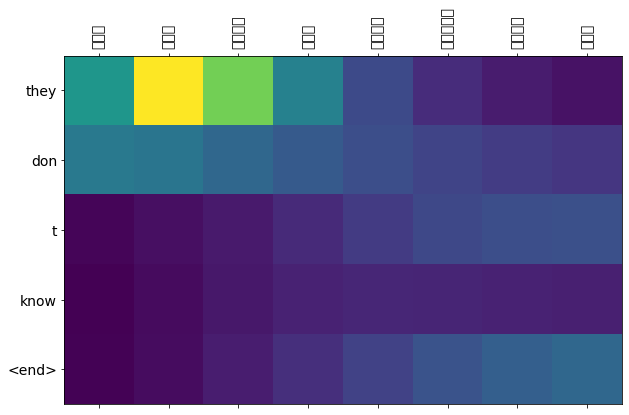

In [44]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("그녀의 경우는 세균들이 얼마나 주변성이 좋아졌는지 입증하는 것이다", encoder, decoder)

Input: 미국 초대 대통령은 워싱턴이다
Predicted translation: london is also <end> 


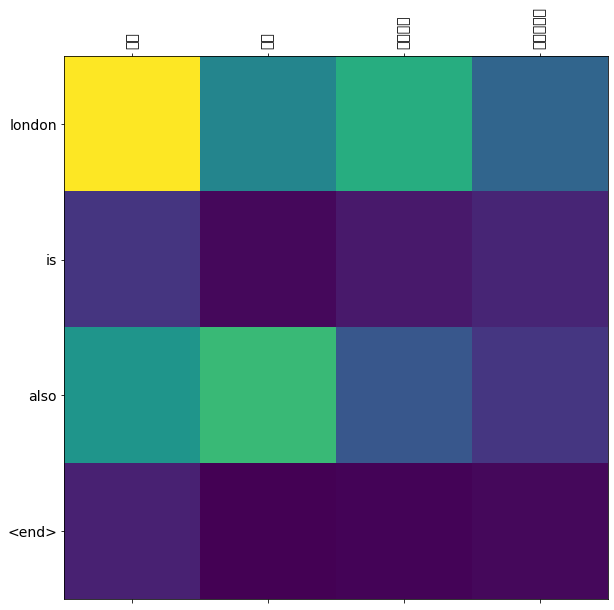

In [45]:
translate("미국 초대 대통령은 워싱턴이다", encoder, decoder)

Input: 오바마가 취임했다
Predicted translation: the best boss . <end> 


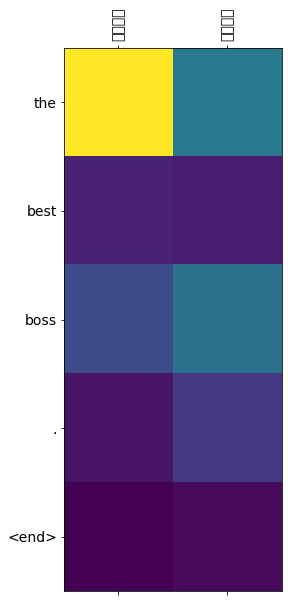

In [48]:
translate("오바마가 취임했다", encoder, decoder)

# 회고
## 1. seq2seq를 이용한 번역기를 만들어봤다. 
## 2. 한국어 Tokenizing 부분에서 꽤 애를 먹었는데, for문을 이용해 비교적 간단히 구현할 수 있는 부분이였다. 아무래도 Tokenizing을 너무 어렵게 생각하고 있는듯 하다.
## 3. 하지만 번역기의 상태는 처참한 수준이다... 번역기를 만든건지 왜곡기를 만든건지 분간이 안간다.